Trajectory Recommendation using a Markov Chain
=====

1. [Features](#sec1)
1. [Load Data](#sec2)
  1. [Compute POI Info](#sec2.1)
  1. [Construct Travelling Sequences](#sec2.2)
  1. [Compute Some Sequence Statistics](#sec2.3)
1. [Compute Transition Probabilities](#sec3)
  1. [Basic Definitions](#sec3.1)
  1. [Transition Probabilities between POI Categories](#sec3.2)
  1. [Transition Probabilities between POI Popularity Classes](#sec3.3)
  1. [Transition Probabilities between POIs](#sec3.4)
  1. [Transition Probabilities between POI Pair Distance Classes](#sec3.5)
1. [Compute Trajectory Likelihood](#sec4)
  1. [Log Likelihood of Actual Trajectories](#sec4.1)
  1. [Log Likelihood of Enumerated Trajectories](#sec4.2)
  1. [Compare the Log Likelihood of Actual and Enumerated Trajectories](#sec4.3)
  1. [Compute the F1-score of Enumerated Trajectories](#sec4.4)

<a id='sec1'></a>

# 1. Features

1. POI category (a transition matrix between different categories)
1. POI popularity (a transition matrix between different class of popularity)
1. POI pair distance (a transition matrix between different class of distance)

**Computation Steps:**
1. First compute the above features using a set of travelling sequences,
1. Next compute a POI-to-POI transition matrix by combing the first two features, 
1. Then compute the log likelihood of (actual/enumerated) sequences using POI-to-POI transition matrix and POI pair distance transition matrix and make comparison.

<a id='sec2'></a>

# 2. Load Data

In [104]:
%matplotlib inline

import os
import re
import math
import random
import pickle
import pandas as pd
import numpy as np
import scipy.stats
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [105]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [106]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [107]:
suffix = fvisit.split('-')[-1].split('.')[0]
fenumseq = os.path.join(data_dir, 'enumSeqData-' + suffix + '.pkl')

In [108]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [109]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


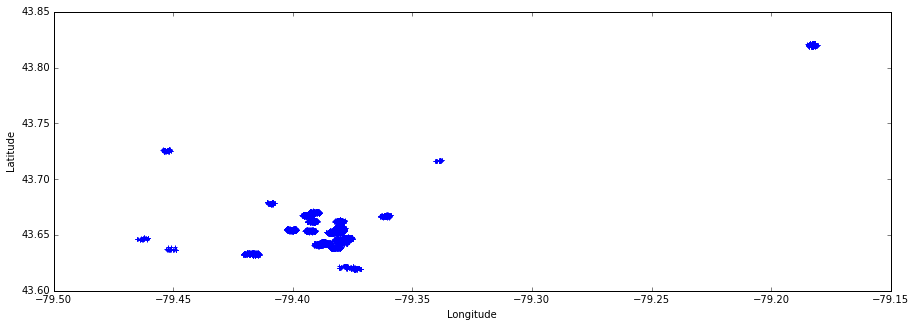

In [110]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

<a id='sec2.1'></a>

## 2.1 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [111]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [112]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [113]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

<a id='sec2.2'></a>

## 2.2 Construct Travelling Sequences

In [114]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [115]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'size':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
seq_user.head()

,userID,poiID
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


<a id='sec2.3'></a>

## 2.3 Compute Some Sequence Statistics

In [116]:
seq_len = seq_all[['seqID', 'poiID']].copy().groupby('seqID').agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_len.head()

,seqID,seqLen
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [117]:
seq_stats = seq_all[['seqID', '#photo', 'poiDuration(sec)']].copy().groupby('seqID').agg(np.sum)
seq_stats.reset_index(inplace=True)
#seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(sec)'}, inplace=True)
seq_stats = pd.merge(seq_len, seq_stats, on='seqID')
seq_stats['poiDuration(sec)'] /= 60
seq_stats.rename(columns={'poiDuration(sec)':'totalPoiDuration(min)'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,seqLen,#photo,totalPoiDuration(min)
seqID,,,
1,1,1,0.000000
2,1,4,9.950000
3,1,1,0.000000
4,1,9,94.566667
5,1,3,4.283333


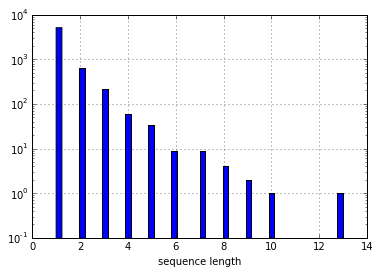

In [118]:
ax = seq_stats['seqLen'].hist(bins=50)
ax.set_xlabel('sequence length')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

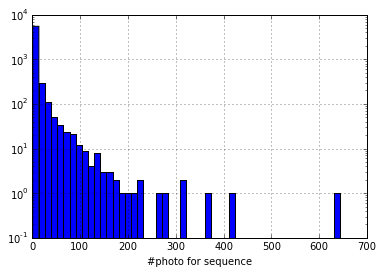

In [119]:
ax = seq_stats['#photo'].hist(bins=50)
ax.set_xlabel('#photo for sequence')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

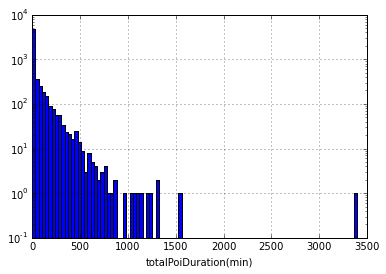

In [120]:
ax = seq_stats['totalPoiDuration(min)'].hist(bins=100)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')
#ax.set_xscale('log')

Sequences with length {3, 4, 5}

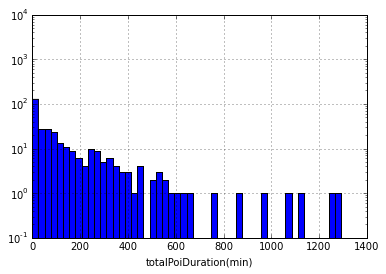

In [121]:
seq_stats = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Do some filtering? (e.g. totalPoiDuration = 0 or too large, seqLen = 1 etc), 8 hours split vs. 6 hours split?

**NOTE: All sequences are used in the next section (i.e. compute sequence log likelihood, enumerate sequences) without any filtering.**

In [122]:
min_duration = 10  # 10 minutes
max_duration = 960 # 16 hours

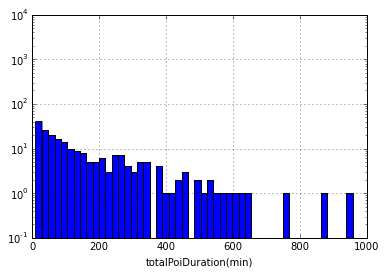

In [123]:
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] > min_duration]
seq_stats = seq_stats[seq_stats['totalPoiDuration(min)'] < max_duration]
ax = seq_stats['totalPoiDuration(min)'].hist(bins=50)
ax.set_xlabel('totalPoiDuration(min)')
ax.set_ylim([0.1, 1e4])
ax.set_yscale('log')

Sequences with the same (start, end), some (start, end) are more popular than others.

what do we need? (start POI category, end POI category) vs. (start POI, end POI)

In [124]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [125]:
seq_dict = dict()
for seqid in seq_stats.index:
    assert(seq_stats.loc[seqid, 'seqLen'] >= 2)
    seq = extract_seq(seqid, seq_all)
    p0 = seq[0]
    pN = seq[-1]
    key = (p0, pN, len(seq))
    if key not in seq_dict:
        seq_dict[key] = []
    seq_dict[key].append(seq)

max: 5 sequences with (start, end, seqLen) (23, 21, 3)
min: 1 sequences with (start, end, seqLen) (3, 22, 3)


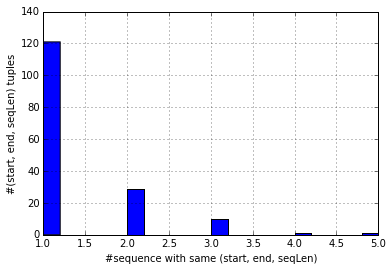

In [126]:
tuples = sorted(seq_dict.keys())
group_size = np.array([len(seq_dict[x]) for x in tuples])
maxidx = group_size.argmax()
minidx = group_size.argmin()
print('max: %d sequences with (start, end, seqLen) %s' % (group_size[maxidx], str(tuples[maxidx])))
print('min: %d sequences with (start, end, seqLen) %s' % (group_size[minidx], str(tuples[minidx])))
ax = pd.Series(group_size).hist(bins=20)
ax.set_xlabel('#sequence with same (start, end, seqLen)')
ax.set_ylabel('#(start, end, seqLen) tuples')

Split sequences into training set and testing set. which kind of split? hold one sequence in each type of (start, end)?

<a id='sec3'></a>

# 3. Compute Transition Probabilities

<a id='sec3.1'></a>

## 3.1 Basic Definitions

- $\text{Pr}(\text{POI}_i \to \text{POI}_j)$: 
   the transition probability from $\text{POI}_i$ to $\text{POI }_j$
- $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

By design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be bigger 
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ becomes bigger (if other factors stay the same).

So how to combine these probabilities?  
Both addition and multiplication seems to be able to serve this purpose, what is the difference?

### The Addition Case

For the addtion case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) + 
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) + 
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

where $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is a normalizing constant.

### The Multiplication Case

For the addtion case, 

\begin{equation}
\text{Pr}(\text{POI}_i \to \text{POI}_j) = \frac{
\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j}) \times
\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j}) \times
\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})
}
{Z_i}
\end{equation}

similarly, $\text{POI}_{i-1}$ is the direct predecessor of $\text{POI}_i$ in a trajectory and $Z_i$ is again a normalizing constant.

### The Difference between Addition and Multiplication

It is important to note the fact that, by design, $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be very small
if any of $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$, $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$ and
$\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$ is very small, in the extreme case, if any of the three probabilities is $0$, then $\text{Pr}(\text{POI}_i \to \text{POI}_j)$ should be $0$
because the event "*Transition from POI$_i$ to POI$_j$*" is impossible.

From the equation of the addition case, it is clear that the addition rule **contradicts** the above fact while the multiplication rule is **consistent** with it.

Intuitively, the addition rule could make an unlikely event become much more likely, specifically, 
make an impossible event become possible.

<a id='sec3.2'></a>

## 3.2 Transition Probabilities between POI Categories

In [127]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()
        if len(nonzeroidx) < transmat.columns.shape[0]:
            minv = np.min(transmat.iloc[row, nonzeroidx])
            EPS = 0.1 * minv  # row-specific smooth factor
            #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
            #transmat.iloc[row, zeroidx] = EPS
            transmat.iloc[row] += EPS
        rowsum = np.sum(transmat.iloc[row])
        assert(rowsum > 0)
        transmat.iloc[row] /= rowsum
    return transmat        

In [128]:
def calc_poi_cat_transmat(seqid_set, poi_all, seq_all):
    poi_cats = poi_all['poiTheme'].unique().tolist()
    poi_cats.sort()
    poi_cat_transmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    index=poi_cats, columns=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']
            poi_cat_transmat.loc[cat1, cat2] += 1
    return poi_cat_transmat

In [129]:
poi_cat_transmat = calc_poi_cat_transmat(seq_all['seqID'].unique(), poi_all, seq_all)
poi_cat_transmat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,14,20,51,17,35,16
Beach,18,43,61,92,19,106
Cultural,46,70,40,72,22,94
Shopping,16,101,58,16,19,71
Sport,42,23,21,13,8,21
Structure,26,91,81,59,24,24


In [130]:
poi_cat_transmat = normalise_transmat(poi_cat_transmat)
poi_cat_transmat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.091503,0.130719,0.333333,0.111111,0.228758,0.104575
Beach,0.053097,0.126844,0.179941,0.271386,0.056047,0.312684
Cultural,0.133721,0.203488,0.116279,0.209302,0.063953,0.273256
Shopping,0.056940,0.359431,0.206406,0.056940,0.067616,0.252669
Sport,0.328125,0.179688,0.164062,0.101562,0.062500,0.164062
Structure,0.085246,0.298361,0.265574,0.193443,0.078689,0.078689


<a id='sec3.3'></a>

## 3.3 Transition Probabilities between POI Popularity Classes

~~**TODO**: Improve the discritization using Fayyad's minimum description length principle (MDLP)  described by [this paper](http://ijcai.org/Past%20Proceedings/IJCAI-93-VOL2/PDF/022.pdf)~~.

**NOTE**: MDLP is a supervised discretization method which requires some sort of class labels that are not available here. We need an unsupervised discretization method, well-known ones including equal width, equal frequency, clustering based, etc.

### 3.3.1 Discretize POI Popularity

What the general criteria of data discretization? [Discretization of continuous features](https://en.wikipedia.org/wiki/Discretization_of_continuous_features) from Wikipedia. 

In [131]:
poi_all['poiFreq'].get_values()

array([3506,  609,  688, 3056,  986, 2064, 1736,  278,  346, 4142,  481,
        964,  141,  113, 3553,  808,   26,  111,   89, 3594, 3619, 1874,
       1028, 1701,  104,  631,  936,  744, 1538])

In [132]:
poi_all['poiFreq'].describe()

count      29.000000
mean     1360.896552
std      1289.191534
min        26.000000
25%       346.000000
50%       936.000000
75%      1874.000000
max      4142.000000
Name: poiFreq, dtype: float64

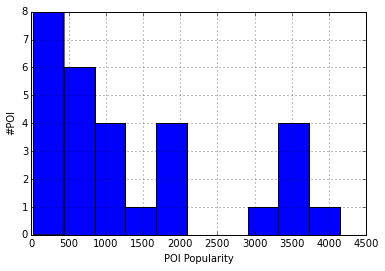

In [133]:
ax = poi_all['poiFreq'].hist(bins=10)
ax.set_xlabel('POI Popularity')
ax.set_ylabel('#POI')

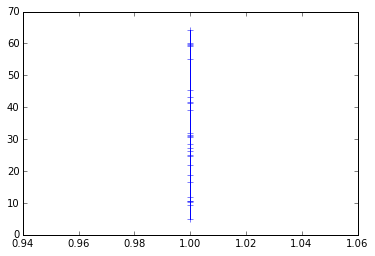

In [134]:
plt.plot(np.ones(poi_all.index.shape[0]), np.sqrt(poi_all['poiFreq']), marker='+')

In [135]:
#bins = [1, 346, 936, 1874, 5000]
#bins = np.linspace(0, 10000, 11)
#bins = np.logspace(0, 4, 5)
#bins = [1, 100, 500, 1000, 2000, 5000]
bins = [1, 500, 1500, 10000]

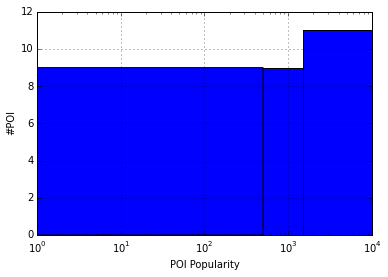

In [136]:
ax = poi_all['poiFreq'].hist(bins=bins)
ax.set_xlabel('POI Popularity')
ax.set_ylabel('#POI')
ax.set_xscale('log')

In [137]:
poi_all['popClass'] = np.digitize(poi_all['poiFreq'].get_values(), bins)
poi_all

,poiTheme,poiFreq,poiLon,poiLat,popClass
poiID,,,,,
1,Sport,3506,-79.379243,43.643183,3
2,Sport,609,-79.418634,43.632772,2
3,Sport,688,-79.380045,43.662175,2
4,Sport,3056,-79.389290,43.641297,3
6,Cultural,986,-79.392396,43.653662,2
7,Cultural,2064,-79.377327,43.647151,3
8,Cultural,1736,-79.385349,43.642385,3
9,Cultural,278,-79.339170,43.716447,1
10,Cultural,346,-79.361107,43.667067,1


### 3.3.2 Compute Transition Probabilities

In [138]:
def calc_poi_pop_transmat(seqid_set, poi_all, seq_all):
    pop_class = poi_all['popClass'].unique().tolist()
    pop_class.sort()
    poi_pop_transmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                    index=pop_class, columns=pop_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            pc1 = poi_all.loc[poi1, 'popClass']
            pc2 = poi_all.loc[poi2, 'popClass']
            poi_pop_transmat.loc[pc1, pc2] += 1
    return poi_pop_transmat

In [139]:
poi_pop_transmat = calc_poi_pop_transmat(seq_all['seqID'].unique(), poi_all, seq_all)
poi_pop_transmat

,1,2,3
1,8,11,18
2,18,52,301
3,12,312,818


In [140]:
poi_pop_transmat = normalise_transmat(poi_pop_transmat)
poi_pop_transmat

,1,2,3
1,0.216216,0.297297,0.486486
2,0.048518,0.140162,0.811321
3,0.010508,0.273205,0.716287


<a id='sec3.4'></a>

## 3.4 Transition Probabilities between POIs

In [141]:
def calc_poi_transmat(poi_all, seq_all, poi_cat_transmat, poi_pop_transmat):
    poi_transmat = pd.DataFrame(data=np.zeros((poi_all.index.shape[0], poi_all.index.shape[0]), dtype=np.float), \
                                index=poi_all.index, columns=poi_all.index)
    for poi1 in poi_all.index:
        cat1 = poi_all.loc[poi1, 'poiTheme']
        pc1  = poi_all.loc[poi1, 'popClass']
        for poi2 in poi_all.index:
            cat2 = poi_all.loc[poi2, 'poiTheme']
            pc2  = poi_all.loc[poi2, 'popClass']
            logP = math.log10(poi_cat_transmat.loc[cat1, cat2]) + math.log10(poi_pop_transmat.loc[pc1, pc2])
            poi_transmat.loc[poi1, poi2] = 10 ** (logP)
    return poi_transmat

In [142]:
poi_transmat = calc_poi_transmat(poi_all, seq_all, poi_cat_transmat, poi_pop_transmat)
poi_transmat

poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
poiID,,,,,,,,,,,,,,,,,,,,,
1,0.044768,0.017075,0.017075,0.044768,0.044823,0.117516,0.117516,0.001724,0.001724,0.117516,...,0.128708,0.128708,0.072748,0.027747,0.072748,0.001067,0.027747,0.044823,0.044823,0.117516
2,0.050708,0.008760,0.008760,0.050708,0.022995,0.133107,0.133107,0.007960,0.007960,0.133107,...,0.145784,0.145784,0.082400,0.014235,0.082400,0.004928,0.014235,0.022995,0.022995,0.133107
3,0.050708,0.008760,0.008760,0.050708,0.022995,0.133107,0.133107,0.007960,0.007960,0.133107,...,0.145784,0.145784,0.082400,0.014235,0.082400,0.004928,0.014235,0.022995,0.022995,0.133107
4,0.044768,0.017075,0.017075,0.044768,0.044823,0.117516,0.117516,0.001724,0.001724,0.117516,...,0.128708,0.128708,0.072748,0.027747,0.072748,0.001067,0.027747,0.044823,0.044823,0.117516
6,0.051887,0.008964,0.008964,0.051887,0.016298,0.094340,0.094340,0.005642,0.005642,0.094340,...,0.165094,0.165094,0.169811,0.029336,0.169811,0.010155,0.029336,0.038300,0.038300,0.221698
7,0.045809,0.017472,0.017472,0.045809,0.031768,0.083289,0.083289,0.001222,0.001222,0.083289,...,0.145756,0.145756,0.149921,0.057182,0.149921,0.002199,0.057182,0.074655,0.074655,0.195730
8,0.045809,0.017472,0.017472,0.045809,0.031768,0.083289,0.083289,0.001222,0.001222,0.083289,...,0.145756,0.145756,0.149921,0.057182,0.149921,0.002199,0.057182,0.074655,0.074655,0.195730
9,0.031113,0.019013,0.019013,0.031113,0.034569,0.056568,0.056568,0.025141,0.025141,0.056568,...,0.098994,0.098994,0.101823,0.062225,0.101823,0.045255,0.062225,0.081238,0.081238,0.132935
10,0.031113,0.019013,0.019013,0.031113,0.034569,0.056568,0.056568,0.025141,0.025141,0.056568,...,0.098994,0.098994,0.101823,0.062225,0.101823,0.045255,0.062225,0.081238,0.081238,0.132935


In [143]:
poi_transmat.sum(axis=1)

poiID
1     1.576483
2     1.634392
3     1.634392
4     1.576483
6     1.657619
7     1.637397
8     1.637397
9     1.560811
10    1.560811
11    1.637397
12    1.560811
13    1.657619
14    1.885533
15    1.885533
16    1.998180
17    2.044765
18    1.885533
19    1.650642
20    1.650642
21    1.774917
22    1.774917
23    1.709562
24    1.786467
25    1.709562
26    1.625277
27    1.786467
28    1.979241
29    1.979241
30    1.884832
dtype: float64

In [144]:
for poi1 in poi_transmat.index:
    rowsum = poi_transmat.loc[poi1].sum()
    #print(rowsum)
    assert(rowsum > 0.)
    #poi_transmat.loc[poi1] /= rowsum # OK
    #print(poi_transmat.loc[poi1].sum())
    logSum = math.log10(rowsum)
    #print(logSum)
    for poi2 in poi_transmat.columns:
        logP = math.log10(poi_transmat.loc[poi1, poi2]) - logSum
        poi_transmat.loc[poi1, poi2] = 10 ** (logP)

In [145]:
poi_transmat

poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
poiID,,,,,,,,,,,,,,,,,,,,,
1,0.028397,0.010831,0.010831,0.028397,0.028432,0.074543,0.074543,0.001094,0.001094,0.074543,...,0.081642,0.081642,0.046146,0.017601,0.046146,0.000677,0.017601,0.028432,0.028432,0.074543
2,0.031025,0.005360,0.005360,0.031025,0.014070,0.081441,0.081441,0.004870,0.004870,0.081441,...,0.089198,0.089198,0.050416,0.008710,0.050416,0.003015,0.008710,0.014070,0.014070,0.081441
3,0.031025,0.005360,0.005360,0.031025,0.014070,0.081441,0.081441,0.004870,0.004870,0.081441,...,0.089198,0.089198,0.050416,0.008710,0.050416,0.003015,0.008710,0.014070,0.014070,0.081441
4,0.028397,0.010831,0.010831,0.028397,0.028432,0.074543,0.074543,0.001094,0.001094,0.074543,...,0.081642,0.081642,0.046146,0.017601,0.046146,0.000677,0.017601,0.028432,0.028432,0.074543
6,0.031302,0.005408,0.005408,0.031302,0.009832,0.056913,0.056913,0.003403,0.003403,0.056913,...,0.099597,0.099597,0.102443,0.017698,0.102443,0.006126,0.017698,0.023105,0.023105,0.133745
7,0.027977,0.010671,0.010671,0.027977,0.019402,0.050867,0.050867,0.000746,0.000746,0.050867,...,0.089017,0.089017,0.091560,0.034923,0.091560,0.001343,0.034923,0.045594,0.045594,0.119537
8,0.027977,0.010671,0.010671,0.027977,0.019402,0.050867,0.050867,0.000746,0.000746,0.050867,...,0.089017,0.089017,0.091560,0.034923,0.091560,0.001343,0.034923,0.045594,0.045594,0.119537
9,0.019934,0.012182,0.012182,0.019934,0.022148,0.036243,0.036243,0.016108,0.016108,0.036243,...,0.063425,0.063425,0.065237,0.039867,0.065237,0.028994,0.039867,0.052049,0.052049,0.085171
10,0.019934,0.012182,0.012182,0.019934,0.022148,0.036243,0.036243,0.016108,0.016108,0.036243,...,0.063425,0.063425,0.065237,0.039867,0.065237,0.028994,0.039867,0.052049,0.052049,0.085171


In [146]:
poi_transmat.sum(axis=1)

poiID
1     1
2     1
3     1
4     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
dtype: float64

<a id='sec3.5'></a>

## 3.5 Transition Probabilities between POI Pair Distance Classes

### TODO: Improve the distance calculation using Google maps [distance API](https://developers.google.com/maps/documentation/distance-matrix/intro) with different [travel modes](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes) demonstrated [here](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/).

### 3.5.1 Compute POI Pair Distance

In [147]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin( math.sqrt( \
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

Compute POI-pair distance if the pair is **observed** in dataset.

In [148]:
def calc_obs_poipair_distmat(seqid_set, poi_all, seq_all):
    poi_distmat = pd.DataFrame(data=np.full((poi_all.shape[0], poi_all.shape[0]), np.nan, dtype=np.float), \
                               index=poi_all.index, columns=poi_all.index)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 2: continue
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            if np.isnan(poi_distmat.loc[poi1, poi2]):
                dist = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                                 poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
                poi_distmat.loc[poi1, poi2] = dist
                poi_distmat.loc[poi2, poi1] = dist
    return poi_distmat

In [149]:
poi_distmat = calc_obs_poipair_distmat(seq_all['seqID'].unique(), poi_all, seq_all)
poi_distmat

poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
poiID,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.374660,NaN,0.835143,NaN,0.467431,0.499234,NaN,3.030221,NaN,...,1.458962,1.094119,1.189309,0.564375,2.183018,NaN,3.137767,1.012704,2.319111,0.294867
2,3.374660,NaN,NaN,2.544650,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.901948,NaN,NaN,NaN,NaN,NaN,NaN,3.380300
3,NaN,NaN,NaN,2.437755,1.372334,1.684876,2.241542,NaN,NaN,NaN,...,0.657012,1.117674,0.923802,2.625464,1.889309,NaN,NaN,1.115082,0.902520,1.837980
4,0.835143,2.544650,2.437755,NaN,1.397423,1.161969,0.339397,NaN,3.653970,2.908190,...,1.810747,1.322054,1.589528,0.634904,1.774903,NaN,NaN,1.374757,NaN,0.851501
6,NaN,NaN,1.372334,1.397423,NaN,1.412097,1.376158,NaN,NaN,1.512543,...,1.003735,0.711743,1.006873,1.858595,0.715967,NaN,1.831988,0.916935,0.946920,1.302621
7,0.467431,NaN,1.684876,1.161969,1.412097,NaN,0.835124,NaN,NaN,2.619294,...,1.045146,0.783543,0.774725,1.030026,2.095884,NaN,2.777055,0.639632,2.008633,0.310629
8,0.499234,NaN,2.241542,0.339397,1.376158,0.835124,NaN,NaN,NaN,2.853071,...,1.593802,1.130084,1.350432,0.484327,NaN,NaN,3.114721,1.139623,2.247435,0.528062
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.054715,...,NaN,7.963547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,3.030221,NaN,NaN,3.653970,NaN,NaN,NaN,NaN,NaN,NaN,...,1.965216,2.436217,NaN,NaN,NaN,NaN,NaN,NaN,2.486915,NaN


### 3.5.2 Discretize POI Pair Distance

In [150]:
#distdata = pd.Series([x for x in np.unique(poi_distmat.get_values().flatten()) if not np.isnan(x)])
distdata = pd.Series([poi_distmat.iloc[x, y] \
                      for x in range(poi_distmat.index.shape[0]) \
                      for y in range(x+1, poi_distmat.index.shape[0]) \
                      if not np.isnan(poi_distmat.iloc[x, y])])

In [151]:
distdata.describe()

count    179.000000
mean       2.069742
std        1.659092
min        0.147439
25%        0.975327
50%        1.710602
75%        2.655934
max        9.857157
dtype: float64

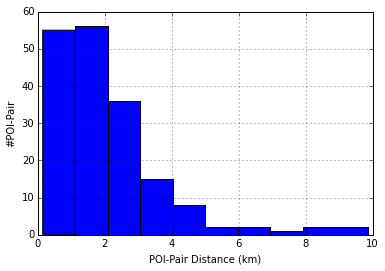

In [152]:
ax = distdata.hist(bins=10)
ax.set_xlabel('POI-Pair Distance (km)')
ax.set_ylabel('#POI-Pair')

In [153]:
#bins = np.linspace(0, 10, 7)
#bins = np.logspace(0, 2, 4)
#bins = [0, 1, 2, 3, 10]
dist_bins = [0, 2, 5, 100] # walk, ride, drive

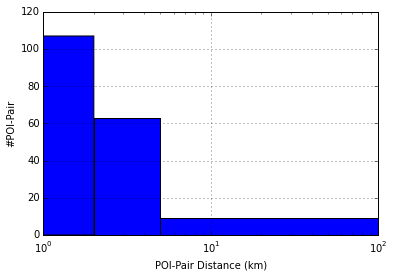

In [154]:
ax = distdata.ix[np.nonzero(distdata)].hist(bins=dist_bins)
ax.set_xlabel('POI-Pair Distance (km)')
ax.set_ylabel('#POI-Pair')
ax.set_xscale('log')

In [155]:
poi_distclass_mat = pd.DataFrame(data=np.full((poi_all.shape[0], poi_all.shape[0]), np.nan, dtype=np.float), \
                                 index=poi_all.index, columns=poi_all.index)

In [156]:
for i in range(poi_all.index.shape[0]):
    poi1 = poi_all.index[i]
    for j in range(i+1, poi_all.index.shape[0]):
        poi2 = poi_all.index[j]
        if np.isnan(poi_distmat.loc[poi1, poi2]): continue
        dc = np.digitize([poi_distmat.loc[poi1, poi2]], dist_bins)[0]
        poi_distclass_mat.loc[poi1, poi2] = dc
        poi_distclass_mat.loc[poi2, poi1] = dc

In [157]:
poi_distclass_mat

poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
poiID,,,,,,,,,,,,,,,,,,,,,
1,NaN,2,NaN,1,NaN,1,1,NaN,2,NaN,...,1,1,1,1,2,NaN,2,1,2,1
2,2,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,2,1,1,2,NaN,NaN,NaN,...,1,1,1,2,1,NaN,NaN,1,1,1
4,1,2,2,NaN,1,1,1,NaN,2,2,...,1,1,1,1,1,NaN,NaN,1,NaN,1
6,NaN,NaN,1,1,NaN,1,1,NaN,NaN,1,...,1,1,1,1,1,NaN,1,1,1,1
7,1,NaN,1,1,1,NaN,1,NaN,NaN,2,...,1,1,1,1,2,NaN,2,1,2,1
8,1,NaN,2,1,1,1,NaN,NaN,NaN,2,...,1,1,1,1,NaN,NaN,2,1,2,1
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN


### 3.5.3 Compute Transition Probabilities

In [158]:
def calc_poipair_dist_transmat(seqid_set, poi_all, seq_all, poi_distclass_mat):
    dist_class = [poi_distclass_mat.iloc[x, y] \
                  for x in range(poi_distclass_mat.index.shape[0]) \
                  for y in range(x+1, poi_distclass_mat.index.shape[0]) \
                  if not np.isnan(poi_distclass_mat.iloc[x, y])]
    dist_class = np.unique(np.array(dist_class))
    poipair_dist_transmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                         index=dist_class, columns=dist_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 3: continue
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dc1 = int(poi_distclass_mat.loc[poi1, poi2])
            dc2 = int(poi_distclass_mat.loc[poi2, poi3])
            assert(not np.isnan(dc1))
            assert(not np.isnan(dc2))
            poipair_dist_transmat.loc[dc1, dc2] += 1
    return poipair_dist_transmat

In [159]:
poipair_dist_transmat = calc_poipair_dist_transmat(seq_all['seqID'].unique(), poi_all, seq_all, poi_distclass_mat)
poipair_dist_transmat

,1.0,2.0,3.0
1,491,35,1
2,31,13,0
3,2,0,0


In [160]:
poipair_dist_transmat = normalise_transmat(poipair_dist_transmat)
poipair_dist_transmat

,1.0,2.0,3.0
1,0.931689,0.066414,0.001898
2,0.674322,0.298539,0.027140
3,0.846154,0.076923,0.076923


<a id='sec4'></a>

# 4. Compute Trajectory Likelihood

In [161]:
def calc_seq_loglikelihood(seq, poi_all, poi_transmat, poi_distclass_mat, poipair_dist_transmat, dist_bins):
    assert(len(seq) > 1)
    logL = math.log10(poi_transmat.loc[seq[0], seq[1]])
    for j in range(1, len(seq)-1):
        poi1 = seq[j-1]
        poi2 = seq[j]
        poi3 = seq[j+1]
        dc12 = poi_distclass_mat.loc[poi1, poi2]
        dc23 = poi_distclass_mat.loc[poi2, poi3]
        if np.isnan(dc12):
            dist12 = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                               poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
            dc12 = np.digitize([dist12], dist_bins)[0]
        if np.isnan(dc23):
            dist23 = calc_dist(poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'], \
                               poi_all.loc[poi3, 'poiLon'], poi_all.loc[poi3, 'poiLat'])
            dc23 = np.digitize([dist23], dist_bins)[0]
        logL += math.log10(poi_transmat.loc[poi2, poi3])
        logL += math.log10(poipair_dist_transmat.loc[dc12, dc23])
    return logL

Simple check.

In [162]:
seq1 = [10, 21, 28, 22]
d12 = calc_dist(poi_all.loc[10,'poiLon'], poi_all.loc[10,'poiLat'], poi_all.loc[21,'poiLon'], poi_all.loc[21, 'poiLat'])
d23 = calc_dist(poi_all.loc[21,'poiLon'], poi_all.loc[21,'poiLat'], poi_all.loc[28,'poiLon'], poi_all.loc[28, 'poiLat'])
d34 = calc_dist(poi_all.loc[28,'poiLon'], poi_all.loc[28,'poiLat'], poi_all.loc[22,'poiLon'], poi_all.loc[22, 'poiLat'])

In [163]:
print(d12, d23, d34, dist_bins)

1.965215721038275 0.45890229014413647 0.20523940866045706 [0, 2, 5, 100]


In [164]:
s1 = math.log10(poi_transmat.loc[10, 21]) + math.log10(poi_transmat.loc[21, 28]) + math.log10(poi_transmat.loc[28, 22])
s2 = math.log10(poipair_dist_transmat.loc[1, 1]) + math.log10(poipair_dist_transmat.loc[1, 1])
print(s1+s2)

-3.489346149470383


In [165]:
calc_seq_loglikelihood([10, 21, 28, 22], poi_all, poi_transmat, poi_distclass_mat, poipair_dist_transmat, dist_bins)

-3.489346149470383

<a id='sec4.1'></a>

## 4.1 Log Likelihood of Actual Trajectories

In [166]:
seqid_set = sorted(seq_all['seqID'].unique().tolist())
act_seq_logL = pd.DataFrame(data=np.zeros((len(seqid_set), 3), dtype=np.object), \
                            index=seqid_set, columns=['actSeq', 'logLikelihood', 'seqLen'])
act_seq_logL.index.name = 'seqID'

In [167]:
for seqid in seqid_set:
    seq = extract_seq(seqid, seq_all)
    logL = 0
    if len(seq) < 2: 
        logL = math.log10(1)
    else:
        logL = calc_seq_loglikelihood(seq, poi_all, poi_transmat, poi_distclass_mat, poipair_dist_transmat, dist_bins)
    act_seq_logL.loc[seqid, 'actSeq'] = str(seq)
    act_seq_logL.loc[seqid, 'seqLen'] = len(seq)
    act_seq_logL.loc[seqid, 'logLikelihood'] = logL
    #print('Sequence %-20s Log likelihood: %.3f' % (str(seq), logL))

In [168]:
act_seq_logL.head()

,actSeq,logLikelihood,seqLen
seqID,,,
1,[30],0,1
2,[6],0,1
3,[6],0,1
4,[13],0,1
5,[24],0,1


In [169]:
seq_345_logL = act_seq_logL[act_seq_logL['seqLen'].isin({3, 4, 5})].copy()
seq_345_logL.sort(columns=['actSeq'], ascending=True, inplace=True)

In [170]:
seq_345_logL

,actSeq,logLikelihood,seqLen
seqID,,,
5927,"[1, 30, 4]",-2.682596,3
852,"[1, 30, 7]",-2.154322,3
2338,"[1, 30, 7]",-2.154322,3
4805,"[1, 7, 28]",-2.499418,3
1171,"[1, 8, 24]",-2.615213,3
1128,"[10, 21, 28, 22]",-3.489346,4
1089,"[11, 13, 30]",-3.763629,3
4973,"[11, 19, 15]",-5.114342,3
1123,"[11, 22, 23, 21]",-2.894671,4


<a id='sec4.2'></a>

## 4.2 Log Likelihood of Enumerated Trajectories

Construct distinct trajectories of length {3, 4, 5}.

In [171]:
seq_345 = dict()

In [172]:
for seqid in sorted(seq_all['seqID'].unique().tolist()):
    seq = extract_seq(seqid, seq_all)
    if len(seq) not in {3, 4, 5}: continue
    if str(seq) not in seq_345:
        seq_345[str(seq)] = [(seqid, seq_user.loc[seqid])]
    else:
        seq_345[str(seq)].append((seqid, seq_user.loc[seqid]))

In [173]:
distinct_seq_345 = sorted([seq_345[x][0][0] for x in sorted(seq_345.keys())])

In [174]:
print(len(distinct_seq_345))
#distinct_seq_345

266


In [175]:
poi_list = poi_all.index.tolist()
#poi_list

Enumerate trajectories of the same (start, end) and length (3, 4 or 5) as an actual sequence.

In [176]:
def enum_345_seq(seqid, poi_list, seq_all): 
    seq = extract_seq(seqid, seq_all)
    assert(len(seq) in {3, 4, 5})
    p0 = seq[0]
    pN = seq[-1]
    
    # enumerate sequences with length 3
    if len(seq) == 3:
        return [[p0, p, pN] \
                for p in poi_list if p not in {p0, pN}]
    
    # enumerate sequences with length 4
    if len(seq) == 4:
        return [[p0, p1, p2, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN}]
    
    # enumerate sequences with length 5
    if len(seq) == 5:
        return [[p0, p1, p2, p3, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN} \
                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]

Compute (or load from .pkl file if possible) the log likelihood of enumerated trajectories.

In [177]:
enum_logL_dict = dict() # key: actual sequence, value: tuple(loglikelihood of actual sequence, enum sequences dataframe)

In [178]:
doEnum = True

In [179]:
if os.path.exists(fenumseq):
    dict1 = pickle.load(open(fenumseq, 'rb'))
    if (np.array(sorted(dict1.keys())) == np.array(sorted(seq_345.keys()))).all():
        doEnum = False
        enum_logL_dict = dict1        

In [180]:
doEnum

False

In [181]:
if doEnum:
    for seqid in distinct_seq_345:
        enum_seqs = enum_345_seq(seqid, poi_list, seq_all)
        df = pd.DataFrame(data=np.array([str(x) for x in enum_seqs]))
        df.columns = ['enumSeq']
        df.set_index('enumSeq', inplace=True)
        df['logLikelihood'] = 0
        for seq in enum_seqs:
            #print(seq)
            logL = calc_seq_loglikelihood(seq, poi_all, poi_transmat, poi_distclass_mat, poipair_dist_transmat, dist_bins)
            df.loc[str(seq), 'logLikelihood'] = logL
        key = seq_345_logL.loc[seqid, 'actSeq']
        df.sort(columns=['logLikelihood'], ascending=False, inplace=True) # sort by the loglikelihood of enum sequences
        enum_logL_dict[key] = (seq_345_logL.loc[seqid, 'logLikelihood'], df)
    pickle.dump(enum_logL_dict, open(fenumseq, 'wb'))

In [182]:
seqidx = 0
seqid = distinct_seq_345[seqidx]
act_seq = seq_345_logL.loc[seqid, 'actSeq']
print('Actual Sequence:', act_seq)
print('Loglikelihood:', enum_logL_dict[act_seq][0])
enum_logL_dict[act_seq][1].head()

Actual Sequence: [7, 11, 27]
Loglikelihood: -2.92158949476864


,logLikelihood
enumSeq,
"[7, 21, 27]",-2.460358
"[7, 11, 27]",-2.921589
"[7, 25, 27]",-3.250408
"[7, 29, 27]",-3.375546
"[7, 6, 27]",-3.494974


In [183]:
rank = 1 + np.nonzero(enum_logL_dict[act_seq][1].index == act_seq)[0][0]
print('rank of actual sequence: %d/%d' % (rank, enum_logL_dict[act_seq][1].index.shape[0]))

rank of actual sequence: 2/27


<a id='sec4.3'></a>

## 4.3 Compare the Log Likelihood of Actual and Enumerated Trajectories

In [184]:
actseqs = sorted(enum_logL_dict.keys())
actseq_logL = [enum_logL_dict[x][0] for x in actseqs]

In [185]:
df = pd.DataFrame(actseqs)
df.columns = ['actSeq']
df['actSeqLogLikelihood'] = [enum_logL_dict[x][0] for x in actseqs]
df['enumSeq'] = [enum_logL_dict[x][1].index[0] for x in actseqs] # the enum sequence with highest log likelihood
df['enumSeqLogLikelihood'] = [enum_logL_dict[x][1].iloc[0]['logLikelihood'] for x in actseqs]
# rank of actual sequence
df['actSeqRank'] = [1+np.nonzero(enum_logL_dict[x][1].index == x)[0][0] for x in actseqs]
df['#enumSeq'] = [enum_logL_dict[x][1].index.shape[0] for x in actseqs]
df['actSeqRank(Top%)'] = 100*df['actSeqRank']/df['#enumSeq']
df

,actSeq,actSeqLogLikelihood,enumSeq,enumSeqLogLikelihood,actSeqRank,#enumSeq,actSeqRank(Top%)
0,"[1, 30, 4]",-2.682596,"[1, 16, 4]",-1.943463,2,27,7.407407
1,"[1, 30, 7]",-2.154322,"[1, 16, 7]",-1.779961,2,27,7.407407
2,"[1, 7, 28]",-2.499418,"[1, 22, 28]",-2.436397,3,27,11.111111
3,"[1, 8, 24]",-2.615213,"[1, 22, 24]",-2.497915,3,27,11.111111
4,"[10, 21, 28, 22]",-3.489346,"[10, 21, 25, 22]",-3.041884,20,702,2.849003
5,"[11, 13, 30]",-3.763629,"[11, 21, 30]",-1.980241,17,27,62.962963
6,"[11, 19, 15]",-5.114342,"[11, 2, 15]",-4.508219,10,27,37.037037
7,"[11, 22, 23, 21]",-2.894671,"[11, 22, 23, 21]",-2.894671,1,702,0.142450
8,"[11, 24, 16, 7]",-4.168811,"[11, 22, 30, 7]",-3.006971,99,702,14.102564
9,"[11, 27, 23]",-4.222023,"[11, 21, 23]",-2.041759,18,27,66.666667


In [186]:
enumseq_logL = [enum_logL_dict[x][1]['logLikelihood'] for x in actseqs]

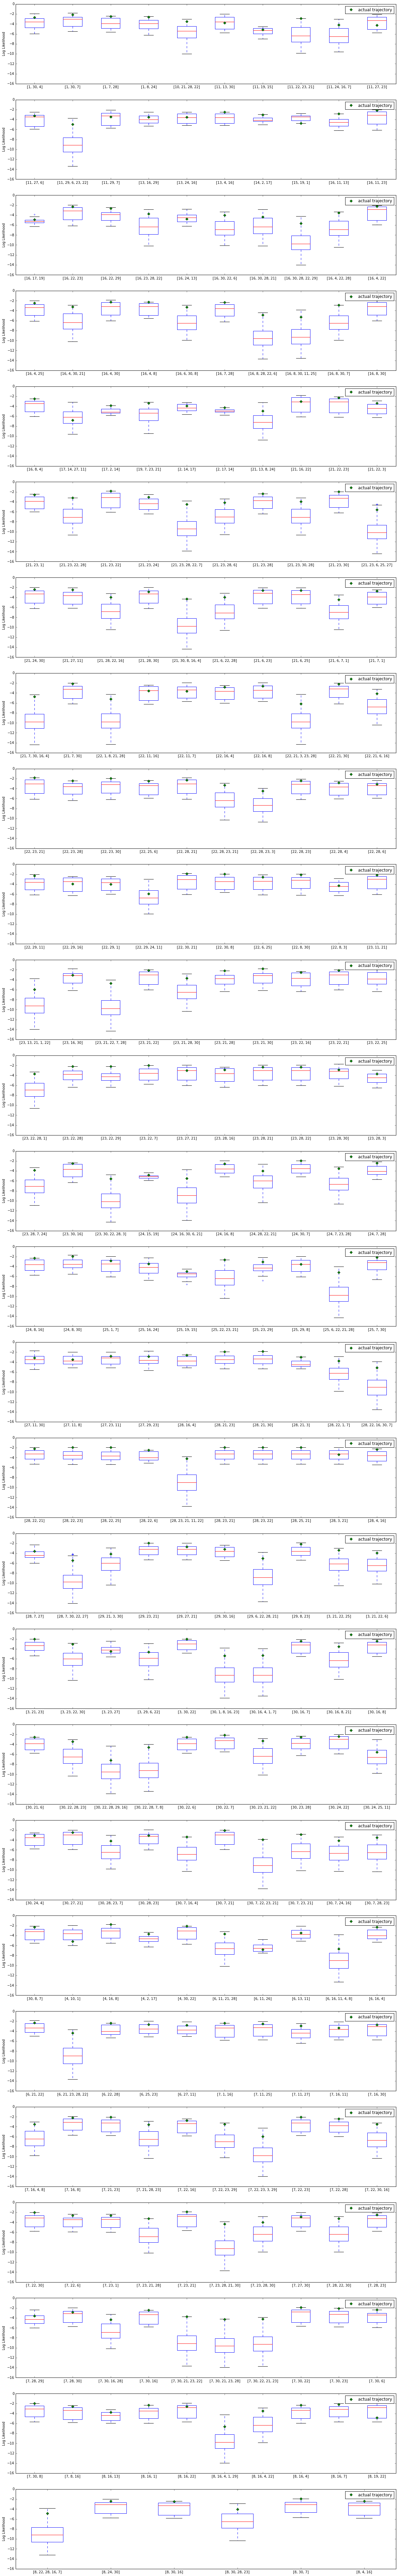

In [187]:
ncol = 10
nrow = int(len(actseqs) / 10)
if len(actseqs) % 10 > 0: nrow += 1
plt.figure(figsize=[20, nrow*5])
for k in range(nrow):
    plt.subplot(nrow, 1, k+1)
    plt.ylim([-16, 0])
    if (k*ncol + ncol) > len(actseqs):
        N = len(actseqs[k*ncol:])
        xidx = range(1, N+1)
        plt.boxplot(enumseq_logL[k*ncol:], labels=actseqs[k*ncol:])
        plt.plot([], 'gD', xdata=xidx, ydata=actseq_logL[k*ncol:], label='actual trajectory')
    else:
        xidx = range(1, ncol+1)
        plt.boxplot(enumseq_logL[k*ncol:(k+1)*ncol], labels=actseqs[k*ncol:(k+1)*ncol])
        plt.plot([], 'gD', xdata=xidx, ydata=actseq_logL[k*ncol:(k+1)*ncol], label='actual trajectory')
    #plt.xlabel('Actual Trajectory')
    plt.ylabel('Log Likelihood')
    plt.legend(numpoints=1)

<a id='sec4.4'></a>

## 4.4 Compute the F1-score of Enumerated Trajectories

In [188]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

In [189]:
def parse_seqstr(seqstr):
    term = re.sub('[ \[\]]', '', seqstr).split(',')
    return [int(x) for x in term]

In [190]:
parse_seqstr(str([3, 11, 27]))

[3, 11, 27]

In [191]:
calc_F1score(parse_seqstr(str([3, 11, 27])), parse_seqstr(str([3, 5, 27])))

0.6666666666666666

In [192]:
calc_F1score(parse_seqstr(str([11, 29, 6, 23, 22])), parse_seqstr(str([11, 29, 6, 23, 22])))

1.0

In [193]:
actseqs = sorted(enum_logL_dict.keys())

In [194]:
df1 = pd.DataFrame(actseqs)
df1.columns = ['actSeq']
df1['enumSeq#1'] = [enum_logL_dict[x][1].index[0] for x in actseqs] # the enum sequence with highest log likelihood
df1['F1-score#1'] = [calc_F1score(parse_seqstr(df1.loc[idx, 'actSeq']), parse_seqstr(df1.loc[idx, 'enumSeq#1'])) \
                     for idx in df1.index]
df1['enumSeq#2'] = [enum_logL_dict[x][1].index[1] for x in actseqs] # the enum sequence with second highest loglikelihood
df1['F1-score#2'] = [calc_F1score(parse_seqstr(df1.loc[idx, 'actSeq']), parse_seqstr(df1.loc[idx, 'enumSeq#2'])) \
                     for idx in df1.index]
df1['enumSeq#3'] = [enum_logL_dict[x][1].index[2] for x in actseqs] # the enum sequence with third highest loglikelihood
df1['F1-score#3'] = [calc_F1score(parse_seqstr(df1.loc[idx, 'actSeq']), parse_seqstr(df1.loc[idx, 'enumSeq#3'])) \
                     for idx in df1.index]

In [195]:
df1.head()

,actSeq,enumSeq#1,F1-score#1,enumSeq#2,F1-score#2,enumSeq#3,F1-score#3
0,"[1, 30, 4]","[1, 16, 4]",0.666667,"[1, 30, 4]",1.000000,"[1, 7, 4]",0.666667
1,"[1, 30, 7]","[1, 16, 7]",0.666667,"[1, 30, 7]",1.000000,"[1, 22, 7]",0.666667
2,"[1, 7, 28]","[1, 22, 28]",0.666667,"[1, 21, 28]",0.666667,"[1, 7, 28]",1.000000
3,"[1, 8, 24]","[1, 22, 24]",0.666667,"[1, 21, 24]",0.666667,"[1, 8, 24]",1.000000
4,"[10, 21, 28, 22]","[10, 21, 25, 22]",0.750000,"[10, 21, 23, 22]",0.750000,"[10, 21, 30, 22]",0.750000


Boxplot of F1-score for top-K (or percent) log likelihood of enumerated trajectories.

In [196]:
topk = 10

In [197]:
enumseq_F1 = [[calc_F1score(parse_seqstr(x), parse_seqstr(enum_logL_dict[x][1].index[y])) \
               for y in range(enum_logL_dict[x][1].index.shape[0]) if y < topk] \
#              for y in range(enum_logL_dict[x][1].index.shape[0]) if y < enum_logL_dict[x][1].index.shape[0]*topk/100] \
               for x in actseqs]

In [198]:
seq0 = actseqs[0]
print(seq0)
print(enum_logL_dict[seq0][1].index.tolist())
print(enumseq_F1[0])
print(len(enumseq_F1))

[1, 30, 4]
['[1, 16, 4]', '[1, 30, 4]', '[1, 7, 4]', '[1, 8, 4]', '[1, 22, 4]', '[1, 21, 4]', '[1, 17, 4]', '[1, 23, 4]', '[1, 25, 4]', '[1, 28, 4]', '[1, 6, 4]', '[1, 11, 4]', '[1, 24, 4]', '[1, 29, 4]', '[1, 13, 4]', '[1, 27, 4]', '[1, 2, 4]', '[1, 3, 4]', '[1, 15, 4]', '[1, 14, 4]', '[1, 18, 4]', '[1, 10, 4]', '[1, 19, 4]', '[1, 12, 4]', '[1, 9, 4]', '[1, 20, 4]', '[1, 26, 4]']
[0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
266


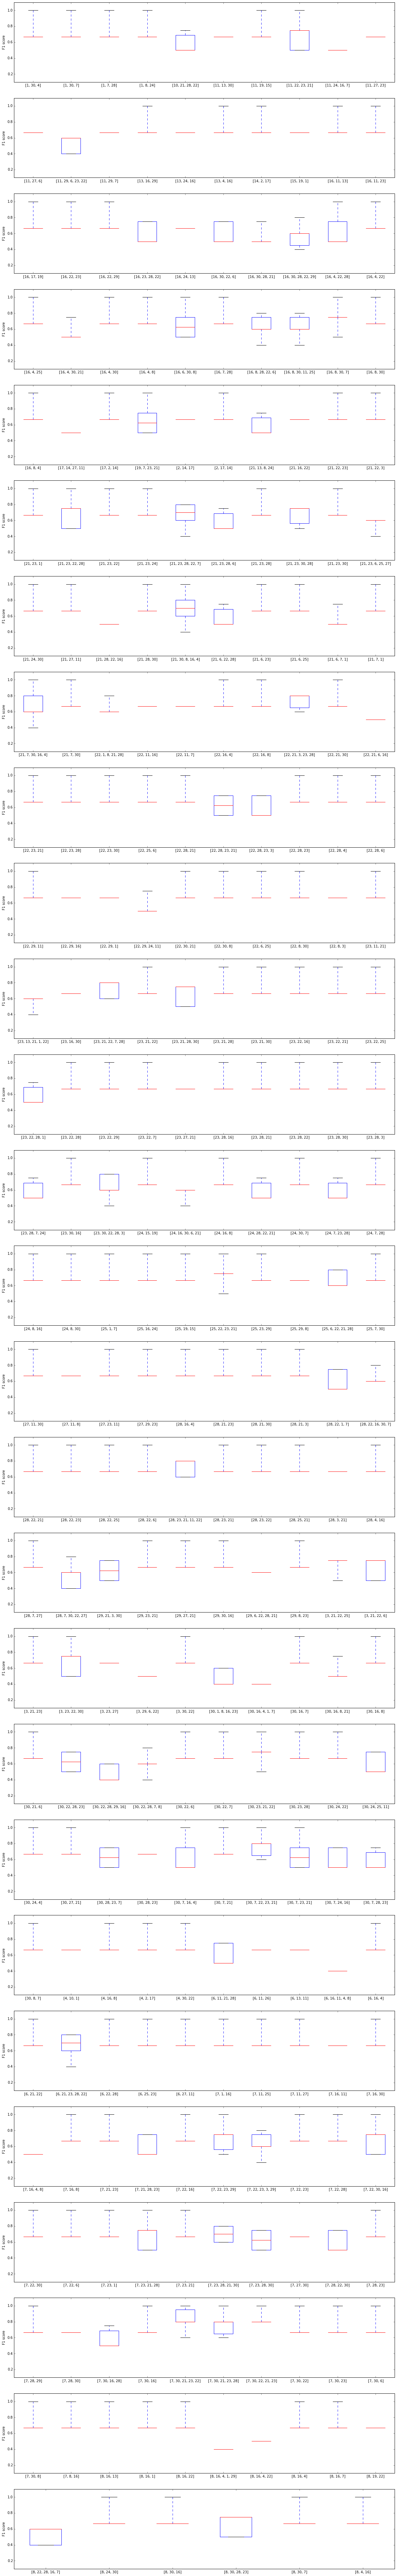

In [199]:
ncol = 10
nrow = int(len(actseqs) / 10)
if len(actseqs) % 10 > 0: nrow += 1
plt.figure(figsize=[20, nrow*5])
for k in range(nrow):
    plt.subplot(nrow, 1, k+1)
    plt.ylim([0.1, 1.1])
    if (k*ncol + ncol) > len(actseqs):
        N = len(actseqs[k*ncol:])
        xidx = range(1, N+1)
        plt.boxplot(enumseq_F1[k*ncol:], labels=actseqs[k*ncol:])
    else:
        xidx = range(1, ncol+1)
        plt.boxplot(enumseq_F1[k*ncol:(k+1)*ncol], labels=actseqs[k*ncol:(k+1)*ncol])
    #plt.xlabel('Actual Trajectory')
    plt.ylabel('F1 score')

Scatter plot of F1 score vs. log likelihood for enumerated trajectories.

In [200]:
print('topk =', topk)
enumseq_logL_list = [enum_logL_dict[x][1].iloc[i]['logLikelihood'] \
                     for x in actseqs \
                     for i in range(enum_logL_dict[x][1].shape[0]) if i < topk]

topk = 10


In [201]:
enumseq_F1_list = [calc_F1score(parse_seqstr(x), parse_seqstr(enum_logL_dict[x][1].index[y])) \
                   for x in actseqs \
                   for y in range(enum_logL_dict[x][1].index.shape[0]) if y < topk]

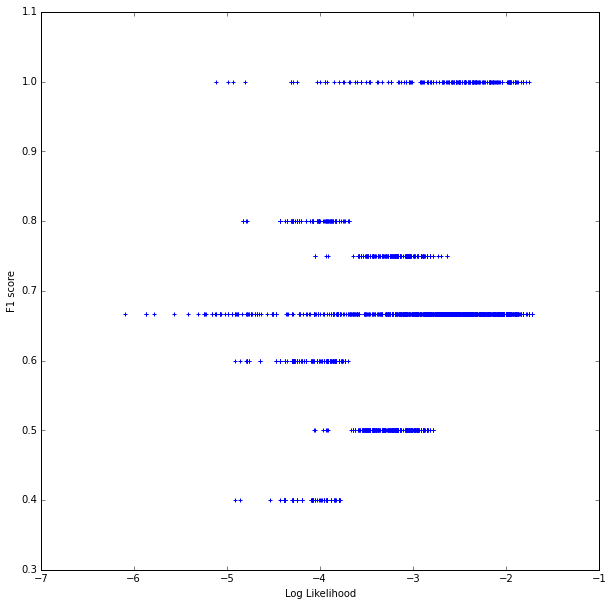

In [202]:
plt.figure(figsize=[10, 10])
plt.xlabel('Log Likelihood')
plt.ylabel('F1 score')
plt.scatter(enumseq_logL_list, enumseq_F1_list, marker='+')

Log Likelihood Rank vs. F1 score Rank.

In [203]:
enumseq_logL_rank = [list(range(1, 1+enum_logL_dict[x][1].index.shape[0])) for x in actseqs] 
# already sorted by loglikelihood

In [204]:
enumseq_F1_rank = []
for x in actseqs:
    F1score = [calc_F1score(parse_seqstr(x), parse_seqstr(enum_logL_dict[x][1].index[y])) \
               for y in range(enum_logL_dict[x][1].index.shape[0])]
    idx = np.argsort(F1score)
    rank = np.zeros(enum_logL_dict[x][1].index.shape[0], dtype=np.int)
    for i in range(len(idx)):
        rank[idx[i]] = i+1
    enumseq_F1_rank.append(rank)

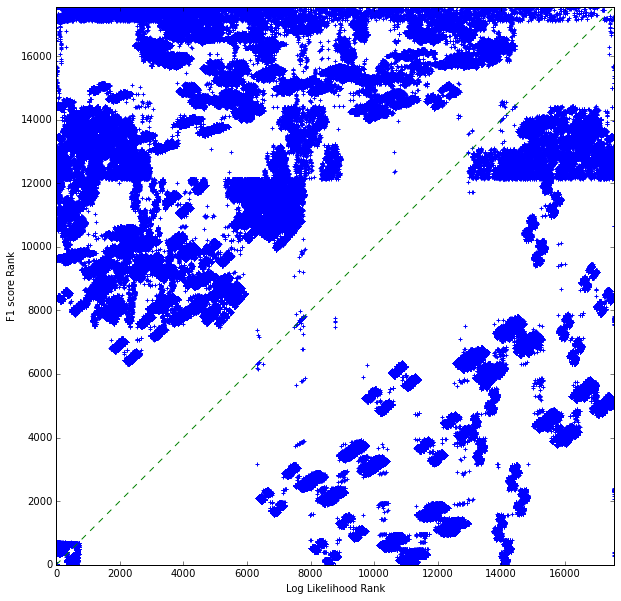

In [205]:
X = [y for x in enumseq_logL_rank for y in x]
Y = [y for x in enumseq_F1_rank for y in x]
plt.figure(figsize=[10, 10])
plt.xlabel('Log Likelihood Rank')
plt.ylabel('F1 score Rank')
plt.xlim([0, max(X)+1])
plt.ylim([0, max(Y)+1])
assert(max(X) == max(Y))
plt.scatter(X, Y, marker='+')
plt.plot([0, max(X)+1], [0, max(Y)+1], linestyle='--', color='g')

Pearson Correlation Coefficient:

In [206]:
scipy.stats.pearsonr(X, Y)

(-0.19296050323235645, 0.0)